<a href="https://colab.research.google.com/github/mariya-goltsova/Parser/blob/main/t5_fine_tuned_with_metrics_20_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentencepiece
!pip install transformers
!pip install rich[jupyter]
!pip install rouge_score
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 72.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=736e6ad1ce511f6d7bf2ca64a5dd53caba9050bd1e3f3b57aec1c91f39c310c6
  Stor

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from datasets import load_dataset, load_metric
dataset = load_dataset('ccdv/arxiv-summarization')

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset arxiv-summarization downloaded and prepared to /root/.cache/huggingface/datasets/ccdv___arxiv-summarization/section/1.0.0/fa2c9abf4312afb8660ef8e041d576b8e3943ea96ae771bd3cd091b5798e7cc3. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
tiny_dataset = dataset['train'].select(list(range(0, 100)))
tiny_dataset_val = dataset['validation'].select(list(range(0, 100)))
text_len = []
summary_len=[]

In [6]:
import pandas as pd
df = pd.DataFrame(tiny_dataset)
df_val = pd.DataFrame(tiny_dataset_val)

df["article"] = "summarize: "+df["article"]
df_val["article"] = "summarize: "+df_val["article"]

In [7]:
df.head()

,article,abstract
0,summarize: additive models @xcite provide an i...,additive models play an important role in semi...
1,summarize: the leptonic decays of a charged ps...,"we have studied the leptonic decay @xmath0 , v..."
2,summarize: the transport properties of nonline...,"in 84 , 258 ( 2000 ) , mateos conjectured that..."
3,summarize: studies of laser beams propagating ...,the effect of a random phase diffuser on fluct...
4,summarize: the so - called `` nucleon spin cri...,with a special intention of clarifying the und...


In [8]:
import time

In [9]:
# load rouge metric
metric = load_metric("rouge")
import evaluate
rouge_score = evaluate.load("rouge")

<ipython-input-9-0d867c56dc7c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


In [10]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import os

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

from rich.table import Column, Table
from rich import box
from rich.console import Console

# define a rich console logger
console=Console(record=True)

def display_df(df):
  """display dataframe in ASCII format"""

  console=Console()
  table = Table(Column("source_text", justify="center" ), Column("target_text", justify="center"), title="Sample Data",pad_edge=False, box=box.ASCII)

  for i, row in enumerate(df.values.tolist()):
    table.add_row(row[0], row[1])

  console.print(table)

training_logger = Table(Column("Epoch", justify="center" ), 
                        Column("Steps", justify="center"),
                        Column("Loss", justify="center"), 
                        title="Training Status",pad_edge=False, box=box.ASCII)
losses = []
rouge = []
val_losses = []

In [11]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [12]:
class YourDataSetClass(Dataset):
  """
  Creating a custom dataset for reading the dataset and 
  loading it into the dataloader to pass it to the neural network for finetuning the model

  """

  def __init__(self, dataframe, tokenizer, source_len, target_len, source_text, target_text):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.source_len = source_len
    self.summ_len = target_len
    self.target_text = self.data[target_text]
    self.source_text = self.data[source_text]

  def __len__(self):
    return len(self.target_text)

  def __getitem__(self, index):
    source_text = str(self.source_text[index])
    target_text = str(self.target_text[index])

    #cleaning data so as to ensure data is in string type
    source_text = ' '.join(source_text.split())
    target_text = ' '.join(target_text.split())

    source = self.tokenizer.batch_encode_plus([source_text], max_length= self.source_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')
    target = self.tokenizer.batch_encode_plus([target_text], max_length= self.summ_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')

    source_ids = source['input_ids'].squeeze()
    source_mask = source['attention_mask'].squeeze()
    target_ids = target['input_ids'].squeeze()
    target_mask = target['attention_mask'].squeeze()

    return {
        'source_ids': source_ids.to(dtype=torch.long), 
        'source_mask': source_mask.to(dtype=torch.long), 
        'target_ids': target_ids.to(dtype=torch.long),
        'target_ids_y': target_ids.to(dtype=torch.long)
    }

In [13]:
from rouge import Rouge

In [14]:
rouge_train = []
def train(epoch, tokenizer, model, device, loader, optimizer):

  """
  Function to be called for training with the parameters passed from main function

  """

  model.train()
  for _,data in enumerate(loader, 0):
    #for time getting 
    torch.cuda.synchronize()
    since = int(round(time.time()*1000))
    #time
    y = data['target_ids'].to(device, dtype = torch.long)
    y_ids = y[:, :-1].contiguous()
    lm_labels = y[:, 1:].clone().detach()
    lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
    ids = data['source_ids'].to(device, dtype = torch.long)
    mask = data['source_mask'].to(device, dtype = torch.long)

    outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
    loss = outputs[0]

    generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=2,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
    preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
    target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]

    rouge_fun1 = Rouge()
    rouge_train.append(rouge_fun1.get_scores(preds, target, avg=True))

    if _%10==0:
      training_logger.add_row(str(epoch), str(_), str(loss))
      console.print(training_logger)
      losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    time_elapsed = int(round(time.time()*1000)) - since
    print ('training time elapsed {}ms'.format(time_elapsed))
    

In [15]:
losses_val = []
def validate(epoch, tokenizer, model, device, loader):

  """
  Function to evaluate model for predictions

  """
  model.eval()
  predictions = []
  actuals = []
  with torch.no_grad():
      for _, data in enumerate(loader, 0):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          y_ids = y[:, :-1].contiguous()
          lm_labels = y[:, 1:].clone().detach()
          lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
          


          # forward propagation (evaluate model on training batch)
          outputs = model(input_ids=ids,
                            attention_mask=mask,
                            labels=lm_labels,
                            decoder_input_ids=y_ids)

          loss, prediction_scores = outputs[:2]
          if _%10==0:
            losses_val.append(loss.item())

          generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=2,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
          preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
          target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
          if _%10==0:
              console.print(f'Completed {_}')

          predictions.extend(preds)
          actuals.extend(target)
          

          #without description rouge:
          #scores = rouge_score.compute(predictions=preds, references=target)
          #rouge.append(scores)


          rouge_fun = Rouge()
          rouge.append(rouge_fun.get_scores(preds, target, avg=True))



  return predictions, actuals

In [16]:
# calculate rouge scores
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [17]:
def T5Trainer(dataframe_train, dataframe_val, source_text, target_text, model_params, output_dir="./outputs/", compute_metrics = compute_metrics, predict_with_generate= True):
  
  """
  T5 trainer

  """

  # Set random seeds and deterministic pytorch for reproducibility
  torch.manual_seed(model_params["SEED"]) # pytorch random seed
  np.random.seed(model_params["SEED"]) # numpy random seed
  torch.backends.cudnn.deterministic = True

  # logging
  console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

  # tokenzier for encoding the text
  tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

  # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
  # Further this model is sent to device (GPU/TPU) for using the hardware.
  model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
  model = model.to(device)
  
  # logging
  console.log(f"[Data]: Reading data...\n")

  # Importing the raw dataset
  #dataframe = dataframe[[source_text,target_text]]
  #display_df(dataframe.head(2))
  dataframe_val = dataframe_val[[source_text,target_text]]
  #display_df(dataframe_val.head(2))
  dataframe_train = dataframe_train[[source_text,target_text]]
  display_df(dataframe_val.head(2))

  
  # Creation of Dataset and Dataloader
  # Defining the train size. So 80% of the data will be used for training and the rest for validation. 
  #train_size = 0.8
  #train_dataset=dataframe.sample(frac=train_size,random_state = model_params["SEED"])
  train_dataset = dataframe_train
  #val_dataset=dataframe.drop(train_dataset.index).reset_index(drop=True)
  val_dataset = dataframe_val.reset_index(drop=True)
  train_dataset = train_dataset.reset_index(drop=True)

  #console.print(f"FULL Dataset: {dataframe.shape}")
  console.print(f"TRAIN Dataset: {train_dataset.shape}")
  console.print(f"TEST Dataset: {val_dataset.shape}\n")


  # Creating the Training and Validation dataset for further creation of Dataloader
  training_set = YourDataSetClass(train_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)
  val_set = YourDataSetClass(val_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)


  # Defining the parameters for creation of dataloaders
  train_params = {
      'batch_size': model_params["TRAIN_BATCH_SIZE"],
      'shuffle': True,
      'num_workers': 0
      }


  val_params = {
      'batch_size': model_params["VALID_BATCH_SIZE"],
      'shuffle': False,
      'num_workers': 0
      }


  # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
  training_loader = DataLoader(training_set, **train_params)
  val_loader = DataLoader(val_set, **val_params)


  # Defining the optimizer that will be used to tune the weights of the network in the training session. 
  optimizer = torch.optim.Adam(params =  model.parameters(), lr=model_params["LEARNING_RATE"])


  # Training loop
  console.log(f'[Initiating Fine Tuning]...\n')

  for epoch in range(model_params["TRAIN_EPOCHS"]):
      train(epoch, tokenizer, model, device, training_loader, optimizer)
      
  console.log(f"[Saving Model]...\n")
  #Saving the model after training
  path = os.path.join(output_dir, "model_files")
  model.save_pretrained(path)
  tokenizer.save_pretrained(path)


  # evaluating test dataset
  console.log(f"[Initiating Validation]...\n")
  for epoch in range(model_params["VAL_EPOCHS"]):
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
    final_df.to_csv(os.path.join(output_dir,'predictions.csv'))
  
  console.save_text(os.path.join(output_dir,'logs.txt'))
  
  console.log(f"[Validation Completed.]\n")
  console.print(f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n""")
  console.print(f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n""")
  console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

In [18]:
model_params={
    "MODEL":"t5-base",             # model_type: t5-base/t5-large
    "TRAIN_BATCH_SIZE":8,          # training batch size
    "VALID_BATCH_SIZE":8,          # validation batch size
    "TRAIN_EPOCHS":20,              # number of training epochs
    "VAL_EPOCHS":10,                # number of validation epochs
    "LEARNING_RATE":1e-4,          # learning rate
    "MAX_SOURCE_TEXT_LENGTH":512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH":50,   # max length of target text
    "SEED": 42                     # set seed for reproducibility 

}

In [19]:
T5Trainer(dataframe_train=df, dataframe_val = df_val, source_text="article", target_text="abstract", model_params=model_params, output_dir="outputs", compute_metrics = compute_metrics,
          predict_with_generate= True)

[14:02:47] [Model]: Loading t5-base...                                           <ipython-input-17-79a50ab207f1>:14
                                                                                                                   

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


[14:03:20] [Data]: Reading data...                                               <ipython-input-17-79a50ab207f1>:25
                                                                                                                   

                                                    Sample Data                                                    
+-----------------------------------------------------------------------------------------------------------------+
|                      source_text                       |                       target_text                      |
|--------------------------------------------------------+--------------------------------------------------------|
|  summarize: the interest in anchoring phenomena and    | we study the phase behavior of a nematic liquid crystal|
|   phenomena in confined nematic liquid crystals has    | confined between a flat substrate with strong anchoring|
| largely been driven by their potential use in liquid   |   and a patterned substrate whose structure and local  |
|               crystal display devices .                |   anchoring strength we vary . by first evaluating an  |
|  the twisted nematic liquid crystal cell serves as an  |  effective surface free energy function characterizing |
|                       example .                        | the patterned substrate we derive an expression for the|
|    it consists of a nematic liquid crystal confined    |  effective free energy of the confined nematic liquid  |
|between two parallel walls , both providing homogeneous |                        crystal .                       |
| planar anchoring but with mutually perpendicular easy  |       then we determine phase diagrams involving a     |
|               directions . in this case                |   homogeneous state in which the nematic director is   |
|  the orientation of the nematic director is tuned by   |  almost uniform and a hybrid aligned nematic state in  |
|  the application of an external electric or magnetic   |  which the orientation of the director varies through  |
|                        field .                         |                       the cell .                       |
|  a precise control of the surface alignment extending  |  direct minimization of the free energy functional were|
|  over large areas is decisive for the functioning of   |    performed in order to test the predictions of the   |
|                    such devices .                      |             effective free energy method .             |
|  most studies have focused on nematic liquid crystals  |   we find remarkably good agreement between the phase  |
| in contact with laterally uniform substrates . on the  |     boundaries calculated from the two approaches .    |
|         other hand substrate inhomogeneities           |  in addition the effective energy method allows one to |
|     arise rather naturally as a result of surface      |  determine the energy barriers between two states in a |
|             treatments such as rubbing .               |                bistable nematic device .               |
|  thus the nematic texture near the surface is in fact  |                                                        |
|                    non - uniform .                     |                                                        |
|    this non - uniformity , however , is smeared out    |                                                        |
| beyond a decay length proportional to the periodicity  |                                                        |
|               of the surface pattern .                 |                                                        |
| very often the thickness of the non - uniform surface  |                                                        |
|layer is considerably smaller than both the wavelength  |                                                        |
|of visible light and the thickness of the nematic cell  |                                                        |
|    , i.e. , the distance between the two confining     |                                                        |
|                    parallel walls                     

TRAIN Dataset: (100, 2)

TEST Dataset: (100, 2)

[14:03:21] [Initiating Fine Tuning]...                                           <ipython-input-17-79a50ab207f1>:80
                                                                                                                   

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 12885ms
training time elapsed 8146ms
training time elapsed 11250ms
training time elapsed 9951ms
training time elapsed 6025ms
training time elapsed 8244ms
training time elapsed 7841ms
training time elapsed 9642ms
training time elapsed 8225ms
training time elapsed 8694ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6586ms
training time elapsed 6460ms
training time elapsed 4406ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6789ms
training time elapsed 5763ms
training time elapsed 7163ms
training time elapsed 5723ms
training time elapsed 7181ms
training time elapsed 5897ms
training time elapsed 6684ms
training time elapsed 6086ms
training time elapsed 6624ms
training time elapsed 6309ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5943ms
training time elapsed 7787ms
training time elapsed 4353ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 7358ms
training time elapsed 6580ms
training time elapsed 7150ms
training time elapsed 6503ms
training time elapsed 6919ms
training time elapsed 5877ms
training time elapsed 6645ms
training time elapsed 6123ms
training time elapsed 6338ms
training time elapsed 6753ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5901ms
training time elapsed 6751ms
training time elapsed 4436ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 7391ms
training time elapsed 5998ms
training time elapsed 7157ms
training time elapsed 5928ms
training time elapsed 7023ms
training time elapsed 5747ms
training time elapsed 4985ms
training time elapsed 6966ms
training time elapsed 5747ms
training time elapsed 7018ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5833ms
training time elapsed 7536ms
training time elapsed 4206ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5904ms
training time elapsed 6531ms
training time elapsed 5717ms
training time elapsed 6523ms
training time elapsed 5161ms
training time elapsed 5616ms
training time elapsed 5843ms
training time elapsed 5582ms
training time elapsed 6686ms
training time elapsed 5358ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 7339ms
training time elapsed 5633ms
training time elapsed 4875ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5812ms
training time elapsed 5702ms
training time elapsed 6691ms
training time elapsed 5991ms
training time elapsed 7341ms
training time elapsed 5721ms
training time elapsed 6880ms
training time elapsed 5748ms
training time elapsed 6403ms
training time elapsed 5399ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5703ms
training time elapsed 6844ms
training time elapsed 4029ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6186ms
training time elapsed 5577ms
training time elapsed 6211ms
training time elapsed 6290ms
training time elapsed 5146ms
training time elapsed 6626ms
training time elapsed 5490ms
training time elapsed 6098ms
training time elapsed 5645ms
training time elapsed 5352ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6684ms
training time elapsed 5666ms
training time elapsed 5465ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5142ms
training time elapsed 5881ms
training time elapsed 6487ms
training time elapsed 5551ms
training time elapsed 7047ms
training time elapsed 5652ms
training time elapsed 6728ms
training time elapsed 5788ms
training time elapsed 5590ms
training time elapsed 5868ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5729ms
training time elapsed 6636ms
training time elapsed 4244ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6310ms
training time elapsed 4858ms
training time elapsed 5708ms
training time elapsed 6847ms
training time elapsed 5785ms
training time elapsed 7170ms
training time elapsed 5778ms
training time elapsed 6356ms
training time elapsed 5664ms
training time elapsed 6058ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6073ms
training time elapsed 4967ms
training time elapsed 4963ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5826ms
training time elapsed 6293ms
training time elapsed 5896ms
training time elapsed 5566ms
training time elapsed 5923ms
training time elapsed 5341ms
training time elapsed 7051ms
training time elapsed 5594ms
training time elapsed 6350ms
training time elapsed 5632ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5713ms
training time elapsed 6147ms
training time elapsed 3878ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6456ms
training time elapsed 5579ms
training time elapsed 6312ms
training time elapsed 6236ms
training time elapsed 5648ms
training time elapsed 6504ms
training time elapsed 5596ms
training time elapsed 6684ms
training time elapsed 5140ms
training time elapsed 6212ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6035ms
training time elapsed 5662ms
training time elapsed 4514ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5397ms
training time elapsed 5591ms
training time elapsed 6139ms
training time elapsed 5789ms
training time elapsed 6699ms
training time elapsed 5786ms
training time elapsed 7183ms
training time elapsed 5617ms
training time elapsed 6009ms
training time elapsed 5645ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5575ms
training time elapsed 6491ms
training time elapsed 4031ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6101ms
training time elapsed 5606ms
training time elapsed 5508ms
training time elapsed 6187ms
training time elapsed 5651ms
training time elapsed 7286ms
training time elapsed 5442ms
training time elapsed 6575ms
training time elapsed 5914ms
training time elapsed 5851ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5604ms
training time elapsed 5566ms
training time elapsed 6008ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5493ms
training time elapsed 6488ms
training time elapsed 5832ms
training time elapsed 6149ms
training time elapsed 6358ms
training time elapsed 5391ms
training time elapsed 6980ms
training time elapsed 5800ms
training time elapsed 7163ms
training time elapsed 5797ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6503ms
training time elapsed 5652ms
training time elapsed 4362ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6885ms
training time elapsed 5742ms
training time elapsed 6871ms
training time elapsed 5513ms
training time elapsed 6644ms
training time elapsed 5751ms
training time elapsed 6018ms
training time elapsed 6543ms
training time elapsed 5757ms
training time elapsed 6838ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5837ms
training time elapsed 7254ms
training time elapsed 4298ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |   0   | tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6027ms
training time elapsed 5979ms
training time elapsed 5841ms
training time elapsed 6071ms
training time elapsed 5296ms
training time elapsed 6653ms
training time elapsed 5542ms
training time elapsed 6429ms
training time elapsed 5777ms
training time elapsed 5597ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |   0   | tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |  10   | tensor(1.1089, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6680ms
training time elapsed 5598ms
training time elapsed 5570ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |   0   | tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |  10   | tensor(1.1089, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |   0   | tensor(0.7933, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5464ms
training time elapsed 6341ms
training time elapsed 5780ms
training time elapsed 5752ms
training time elapsed 6480ms
training time elapsed 5582ms
training time elapsed 6864ms
training time elapsed 5525ms
training time elapsed 6907ms
training time elapsed 5612ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |   0   | tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |  10   | tensor(1.1089, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |   0   | tensor(0.7933, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |  10   | tensor(0.9735, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6298ms
training time elapsed 5896ms
training time elapsed 4256ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |   0   | tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |  10   | tensor(1.1089, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |   0   | tensor(0.7933, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |  10   | tensor(0.9735, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |   0   | tensor(0.4505, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 7236ms
training time elapsed 5509ms
training time elapsed 6480ms
training time elapsed 5666ms
training time elapsed 6160ms
training time elapsed 5671ms
training time elapsed 5588ms
training time elapsed 6779ms
training time elapsed 5729ms
training time elapsed 7179ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |   0   | tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |  10   | tensor(1.1089, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |   0   | tensor(0.7933, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |  10   | tensor(0.9735, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |   0   | tensor(0.4505, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |  10   | tensor(1.0057, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5654ms
training time elapsed 6612ms
training time elapsed 4212ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |   0   | tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |  10   | tensor(1.1089, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |   0   | tensor(0.7933, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |  10   | tensor(0.9735, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |   0   | tensor(0.4505, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |  10   | tensor(1.0057, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 18   |   0   | tensor(0.8351, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5641ms
training time elapsed 6824ms
training time elapsed 5584ms
training time elapsed 7084ms
training time elapsed 5597ms
training time elapsed 6395ms
training time elapsed 5699ms
training time elapsed 5149ms
training time elapsed 6570ms
training time elapsed 5629ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |   0   | tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |  10   | tensor(1.1089, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |   0   | tensor(0.7933, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |  10   | tensor(0.9735, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |   0   | tensor(0.4505, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |  10   | tensor(1.0057, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 18   |   0   | tensor(0.8351, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 18   |  10   | tensor(0.7607, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6951ms
training time elapsed 5729ms
training time elapsed 4758ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |   0   | tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |  10   | tensor(1.1089, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |   0   | tensor(0.7933, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |  10   | tensor(0.9735, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |   0   | tensor(0.4505, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |  10   | tensor(1.0057, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 18   |   0   | tensor(0.8351, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 18   |  10   | tensor(0.7607, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 19   |   0   | tensor(0.6094, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5876ms
training time elapsed 5182ms
training time elapsed 6759ms
training time elapsed 5579ms
training time elapsed 6952ms
training time elapsed 5628ms
training time elapsed 6048ms
training time elapsed 5687ms
training time elapsed 5696ms
training time elapsed 6423ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |   0   | tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  3   |  10   | tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |   0   | tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  4   |  10   | tensor(2.6958, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |   0   | tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  5   |  10   | tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |   0   | tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  6   |  10   | tensor(1.6952, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |   0   | tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  7   |  10   | tensor(1.8853, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |   0   | tensor(1.9336, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  8   |  10   | tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |   0   | tensor(1.5618, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  9   |  10   | tensor(1.6393, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |   0   | tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 10   |  10   | tensor(1.2422, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |   0   | tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 11   |  10   | tensor(1.4459, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |   0   | tensor(1.5366, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 12   |  10   | tensor(1.2956, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |   0   | tensor(1.3097, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 13   |  10   | tensor(1.0994, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |   0   | tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 14   |  10   | tensor(0.9194, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |   0   | tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 15   |  10   | tensor(1.1089, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |   0   | tensor(0.7933, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 16   |  10   | tensor(0.9735, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |   0   | tensor(0.4505, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 17   |  10   | tensor(1.0057, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 18   |   0   | tensor(0.8351, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 18   |  10   | tensor(0.7607, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 19   |   0   | tensor(0.6094, device='cuda:0', grad_fn=<NllLossBackward0>)|
| 19   |  10   | tensor(0.4753, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5562ms
training time elapsed 6989ms
training time elapsed 4345ms


[14:31:38] [Saving Model]...                                                     <ipython-input-17-79a50ab207f1>:85
                                                                                                                   

[14:31:41] [Initiating Validation]...                                            <ipython-input-17-79a50ab207f1>:93
                                                                                                                   

Completed 0

Completed 10

Completed 0

Completed 10

Completed 0

Completed 10

Completed 0

Completed 10

Completed 0

Completed 10

Completed 0

Completed 10

Completed 0

Completed 10

Completed 0

Completed 10

Completed 0

Completed 10

Completed 0

Completed 10

[14:43:21] [Validation Completed.]                                              <ipython-input-17-79a50ab207f1>:101
                                                                                                                   

[Model] Model saved @ outputs/model_files

[Validation] Generation on Validation data saved @ outputs/predictions.csv

[Logs] Logs saved @ outputs/logs.txt

PLOT RESULTS

In [46]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import wandb
import WandbLogger

YOUR_API_KEY = 'd08ca5f4bbe65830fbdb53434c84b55a0dc10bbd'
os.environ["WANDB_API_KEY"] = YOUR_API_KEY
wandb_logger = WandbLogger(project='t5')
wandb.init(project="t5 plots")

ModuleNotFoundError: ignored

In [36]:
print(losses)
print(rouge)
print(losses_val)
print(rouge_train)

[7.237138271331787, 3.542572021484375, 3.613893985748291, 3.15901517868042, 3.1058733463287354, 2.400657892227173, 2.4711344242095947, 2.685175657272339, 2.3868930339813232, 2.695833444595337, 2.4530484676361084, 2.3688290119171143, 2.1252052783966064, 1.6952145099639893, 2.0309717655181885, 1.885251760482788, 1.9335834980010986, 1.7774453163146973, 1.5618184804916382, 1.6392816305160522, 2.1309618949890137, 1.2421876192092896, 1.726819396018982, 1.445873498916626, 1.536557674407959, 1.295619010925293, 1.309706211090088, 1.099448323249817, 1.2096041440963745, 0.91944420337677, 1.0657634735107422, 1.1089106798171997, 0.7932977676391602, 0.9735165238380432, 0.45053747296333313, 1.005685806274414, 0.8350707292556763, 0.7606620788574219, 0.6094198226928711, 0.47534435987472534]
[{'rouge-1': {'r': 0.34357534477033547, 'p': 0.19755865571956543, 'f': 0.24863501879510277}, 'rouge-2': {'r': 0.1047026068491913, 'p': 0.05710805640705498, 'f': 0.07336705257954726}, 'rouge-l': {'r': 0.3061703890028

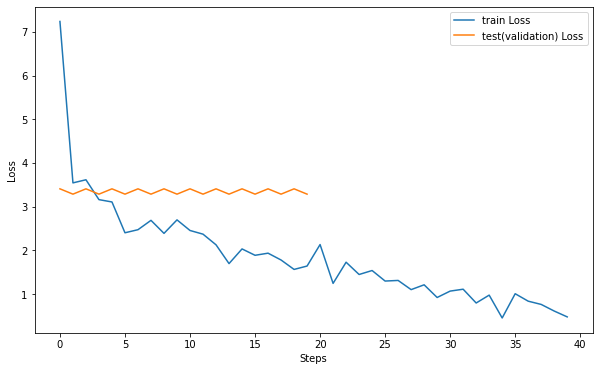

Error: ignored

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(losses, label="train Loss")
plt.plot(losses_val, label="test(validation) Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()
wandb.log({"train Loss": plt})

In [38]:
scores = pd.DataFrame(rouge)
rouge1 = pd.DataFrame(scores['rouge-1'].to_list())
rouge2 = pd.DataFrame(scores['rouge-2'].to_list())
rougeL = pd.DataFrame(scores['rouge-l'].to_list())

scores.keys()

Index(['rouge-1', 'rouge-2', 'rouge-l'], dtype='object')

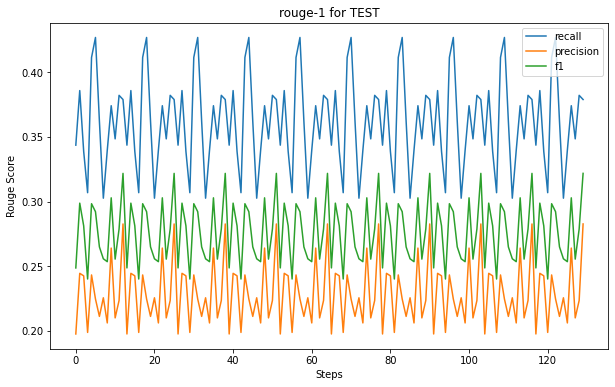

Error: ignored

In [39]:
plt.figure(figsize=(10,6))

plt.title('rouge-1 for TEST')
plt.plot(rouge1['r'].to_list(), label="recall")
plt.plot(rouge1['p'], label="precision")
plt.plot(rouge1['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()
wandb.log({"rouge-1 for TEST": plt})

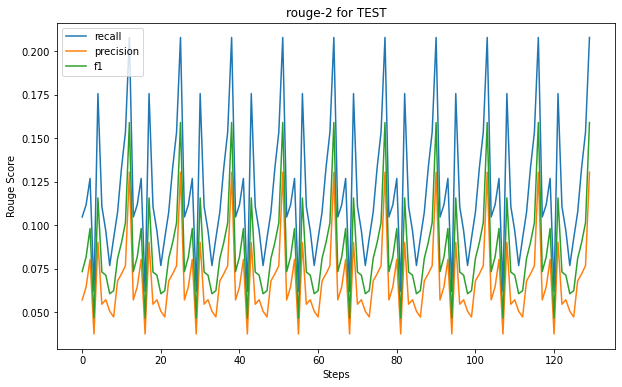

Error: ignored

In [40]:
plt.figure(figsize=(10,6))

plt.title('rouge-2 for TEST')
plt.plot(rouge2['r'].to_list(), label="recall")
plt.plot(rouge2['p'], label="precision")
plt.plot(rouge2['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()
wandb.log({"rouge-2 for TEST": plt})

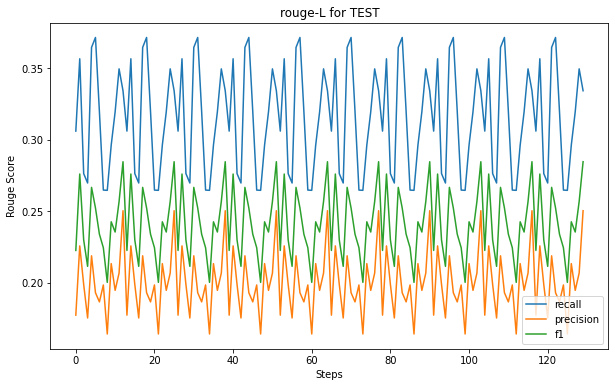

Error: ignored

In [41]:
plt.figure(figsize=(10,6))

plt.title('rouge-L for TEST')
plt.plot(rougeL['r'].to_list(), label="recall")
plt.plot(rougeL['p'], label="precision")
plt.plot(rougeL['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()

wandb.log({"rouge-L for TEST": plt})

In [42]:
scores_t = pd.DataFrame(rouge_train)
rouge1_t = pd.DataFrame(scores_t['rouge-1'].to_list())
rouge2_t = pd.DataFrame(scores_t['rouge-2'].to_list())
rougeL_t = pd.DataFrame(scores_t['rouge-l'].to_list())

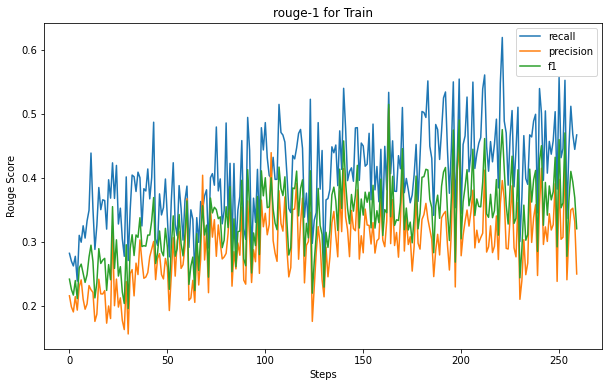

Error: ignored

In [43]:
plt.figure(figsize=(10,6))

plt.title('rouge-1 for Train')
plt.plot(rouge1_t['r'].to_list(), label="recall")
plt.plot(rouge1_t['p'], label="precision")
plt.plot(rouge1_t['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()

wandb.log({"rouge-1 for TRAIN": plt})

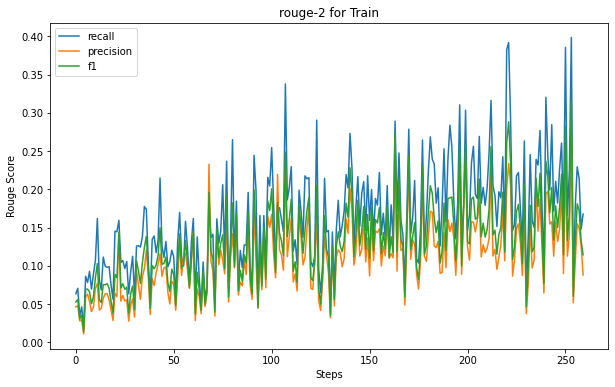

Error: ignored

In [44]:
plt.figure(figsize=(10,6))

plt.title('rouge-2 for Train')
plt.plot(rouge2_t['r'].to_list(), label="recall")
plt.plot(rouge2_t['p'], label="precision")
plt.plot(rouge2_t['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()
wandb.log({"rouge-2 for TRAIN": plt})

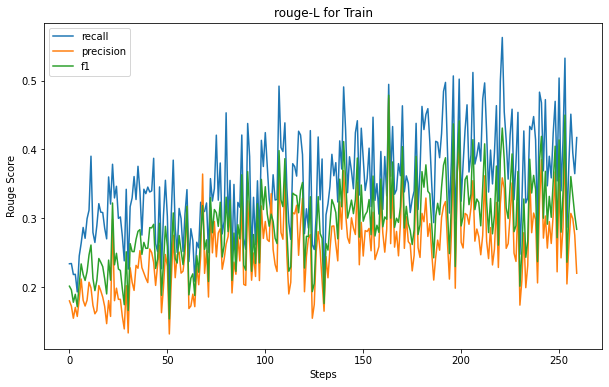

Error: ignored

In [48]:
plt.figure(figsize=(10,6))

plt.title('rouge-L for Train')
plt.plot(rougeL_t['r'].to_list(), label="recall")
plt.plot(rougeL_t['p'], label="precision")
plt.plot(rougeL_t['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()
wandb.log({"rouge-L for TRAIN": plt})